Predictive modeling and analysis to assess the risk of loan defaults using logistic regression and decision trees.

In [1]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [2]:
# Load the loan dataset
data = pd.read_csv('Loan_Data.csv')  # Load data from a CSV file
data.head()  # Display the first five rows of the dataset to understand its structure

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
# Display data types and non-null counts for each column to check for missing values and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


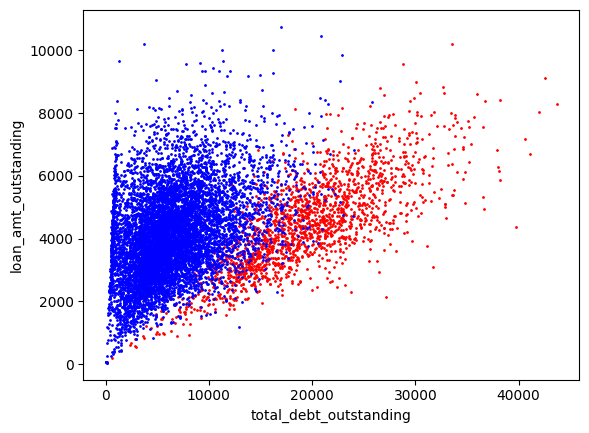

In [4]:
# Visualize the relationship between total debt and loan amount by default status
plt.clf()  # Clear any previous plots
plt.xlabel('total_debt_outstanding')
plt.ylabel('loan_amt_outstanding')

# Red points for defaulted loans, blue for non-defaulted loans
plt.scatter(data[data['default'] == 1]['total_debt_outstanding'], data[data['default'] == 1]['loan_amt_outstanding'], c='r', s=1)
plt.scatter(data[data['default'] == 0]['total_debt_outstanding'], data[data['default'] == 0]['loan_amt_outstanding'], c='b', s=1)
plt.show()

In [5]:
# Feature engineering: Create new variables for debt-to-loan and debt-to-income ratios
data['debt_to_loan'] = data['total_debt_outstanding'] / data['loan_amt_outstanding']
data['debt_to_income'] = data['total_debt_outstanding'] / data['income']
data

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_to_loan,debt_to_income
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,0.749868,0.050173
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,4.200639,0.308789
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,0.602981,0.030787
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,0.524841,0.033645
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,1.314304,0.075435
...,...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,0.841803,0.059818
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,1.316413,0.068253
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,1.558531,0.126021
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,0.317157,0.020481


In [6]:
# Compute the average ratios for defaulted and non-defaulted loans
debt_to_loan_defaulted = data[data['default'] == 1]['debt_to_loan'].mean()
debt_to_loan_notdefaulted = data[data['default'] == 0]['debt_to_loan'].mean()

debt_to_income_defaulted = data[data['default'] == 1]['debt_to_income'].mean()
debt_to_income_notdefaulted = data[data['default'] == 0]['debt_to_income'].mean()

# Print the mean ratios for default comparison
print(debt_to_loan_defaulted, debt_to_loan_notdefaulted, debt_to_income_defaulted, debt_to_income_notdefaulted)

4.445373757444491 1.6006943643749982 0.272104678726068 0.0903809375257615


In [7]:
# Summary statistics for defaulted loans to understand the distribution of variables
print(data[data['default'] == 1].describe())

        customer_id  credit_lines_outstanding  loan_amt_outstanding  \
count  1.851000e+03               1851.000000           1851.000000   
mean   5.007914e+06                  4.618044           4454.854897   
std    2.278015e+06                  0.637969           1471.586769   
min    1.000324e+06                  2.000000            189.725024   
25%    3.016468e+06                  4.000000           3395.163895   
50%    5.116813e+06                  5.000000           4393.697084   
75%    6.972913e+06                  5.000000           5388.006613   
max    8.989969e+06                  5.000000          10210.746690   

       total_debt_outstanding         income  years_employed   fico_score  \
count             1851.000000    1851.000000     1851.000000  1851.000000   
mean             19270.582961   70726.740140        3.617504   596.257699   
std               6298.378378   20363.512385        1.401002    58.949929   
min                592.445977    2836.241899        

In [8]:
# Select features for machine learning models
features = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'debt_to_loan', 'debt_to_income']

Not resampling data because class imbalance is not extreme. 18% default data 82% non default.

In [9]:
# Copy the data for modeling, specify target and input features
df = data.copy()
y = df['default']  # Target variable
X = df[features]  # Input features

# Split data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train logistic regression and decision tree classifiers
logistic_model = LogisticRegression(max_iter=10000)
decision_tree_model = DecisionTreeClassifier()
logistic_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)

# Predict default probabilities and evaluate model performance using ROC AUC
logistic_predictions_balanced = logistic_model.predict_proba(X_test)[:, 1]
tree_predictions_balanced = decision_tree_model.predict_proba(X_test)[:, 1]
logistic_auc_balanced = roc_auc_score(y_test, logistic_predictions_balanced)
tree_auc_balanced = roc_auc_score(y_test, tree_predictions_balanced)

print(logistic_auc_balanced, tree_auc_balanced)

0.9999895633297153 0.9851764493056135


Expected Loss=Probability of Default×(1 - Recovery Rate)×Loan Amount

In [10]:
# Define a function to calculate the expected financial loss from a loan
def calculate_expected_loss(model, features, loan_amount, recovery_rate=0.10):
    """
    Calculate expected loss for a loan based on the probability of default and recovery rate.
    
    Parameters:
    - model: Trained machine learning model for default prediction.
    - features: DataFrame or array-like, features of the loan.
    - loan_amount: float, the outstanding amount of the loan.
    - recovery_rate: float, the expected recovery rate in the event of a default.
    
    Returns:
    - expected_loss: float, the expected monetary loss on the loan.
    """
    probability_of_default = model.predict_proba(features)[:, 1]  # Predict the probability of default
    expected_loss = probability_of_default * (1 - recovery_rate) * loan_amount  # Calculate expected loss
    return expected_loss

In [11]:
test_loan_features = pd.DataFrame([{
    'credit_lines_outstanding': 3,
    'loan_amt_outstanding': 5000,  # $5,000 loan
    'total_debt_outstanding': 7500,  # Total debt $7,500
    'income': 55000,  # Annual income $55,000
    'years_employed': 4,
    'fico_score': 610,
    'debt_to_loan': 1.5,
    'debt_to_income': 0.15
}])
expected_loss_example = calculate_expected_loss(logistic_model, test_loan_features, 5000)
print(f'Expected loss is: ${round(expected_loss_example[-1],2)}')

Expected loss is: $23.66
